In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.cm as cm
import imageio
from IPython.display import HTML, Latex, display, Math
from mpi4py import MPI
import numpy as np
import math
from matplotlib.patches import Polygon

from pylab import rcParams
rcParams['figure.figsize'] = 14, 11
# matplotlib.rc('font', **{'size': 20})
%matplotlib inline

In [2]:
class Function():
    def __init__(self, expression, diapason=(0, 1), function_name='f'):
        self.expression = expression
        self.function_name = function_name
        self.frm, self.to = diapason
        
        rcParams['figure.figsize'] = 14, 11
        plt.rc('xtick', labelsize=18) 
        plt.rc('ytick', labelsize=18) 
        plt.rcParams.update({'font.size': 20})

    def __call__(self, point=0):
        print('{}({}) = {}'.format(self.function_name, point, self._get_value(point)))
        
    @property
    def diapason(self):
        return (self.frm, self.to)
    
    @diapason.setter
    def diapason(self, value):
        self.frm, self.to = value
        
    def _get_value(self, x):
        return eval(self.expression)
    
    def draw(self, include_segments=False, segments_count=2):
        rng = np.linspace(self.frm, self.to, 101)
        values = [self._get_value(i) for i in rng]
        
        fig, ax = plt.subplots()
        plt.title('Function')
        plt.xlabel('x')
        plt.ylabel('{}(x)'.format(self.function_name))
        plt.plot(rng, values)
        
        if include_segments:
#             verts = [*zip(rng, values)]
#             poly = Polygon(verts, facecolor='0.8', edgecolor='0.5')
#             ax.add_patch(poly)
            
            segments = self._get_segments(segments_count)
            values = [self._get_value(p) for p in segments]
            plt.plot(segments, values, color='orange')
            
            for s in range(segments_count+1):
                plt.plot((segments[s], segments[s]), (0, values[s]), color='orange')                
        
        plt.show()
                
    def _get_segments(self, count=1):
        return np.linspace(self.frm, self.to, count+1)
    
    def count_area(self, segments_count=2, processes=1):
        points = self._get_segments(segments_count)
        segments = [[points[p-1], points[p]] for p in range(1, len(points))]
        
        if processes == 1:
            sum = 0
            for s in segments:
                sum += self.count_segment(s[0], s[1])
            return sum
        else:
            pass
    
    def count_segment(self, start, end):
        return (end - start) * (self._get_value(start) + self._get_value(end)) / 2
    

# Example
<big> $ S = \displaystyle \int_a^b  \displaystyle \frac{1}{\sqrt{1 + x^2}} \, dx$ </big>, where $a = 5$ and $b = 7$

Let's compute analytically the value of $S$

<big> $ S = \displaystyle \int_a^b  \displaystyle \frac{1}{\sqrt{1 + x^2}} \, dx = $ </big>
<big> $ ln|x+\sqrt{x^2 + 1}| \Bigg| _{a} ^{b} = $ </big>
<big> $ ln|x+\sqrt{x^2 + 1}| \Bigg| _{5} ^{7} = ln|7+\sqrt{50}| - ln|5+\sqrt{26}| \approx 0.33 $ </big>

In [5]:
a, b = 5, 7
fexact_solution = math.log(abs(b + math.sqrt(b**2 + 1))) - math.log(abs(a + math.sqrt(a**2 + 1)))
fexact_solution

0.33168241978587654

In [6]:
f = Function('1 / math.sqrt(1 + x**2)', diapason=(a, b))

We can approximate the function with trapezes:
$\displaystyle \int_{a}^{b} f(x) \approx S_D = \displaystyle \sum_{k = 1}^{N-1} \displaystyle \frac{f\left(a + k \,\tau\right)+ f\left(a + \left(k - 1\right) \tau\right) }{2}\,\,\tau$, where $ a + (N - 1)\tau = b$

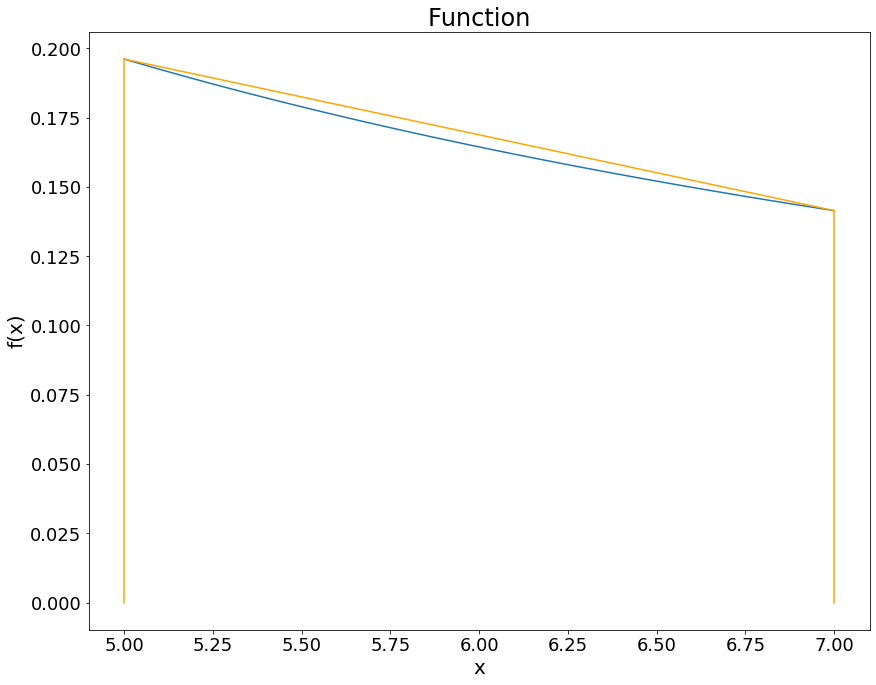

In [56]:
f.draw(include_segments=True, segments_count=1)

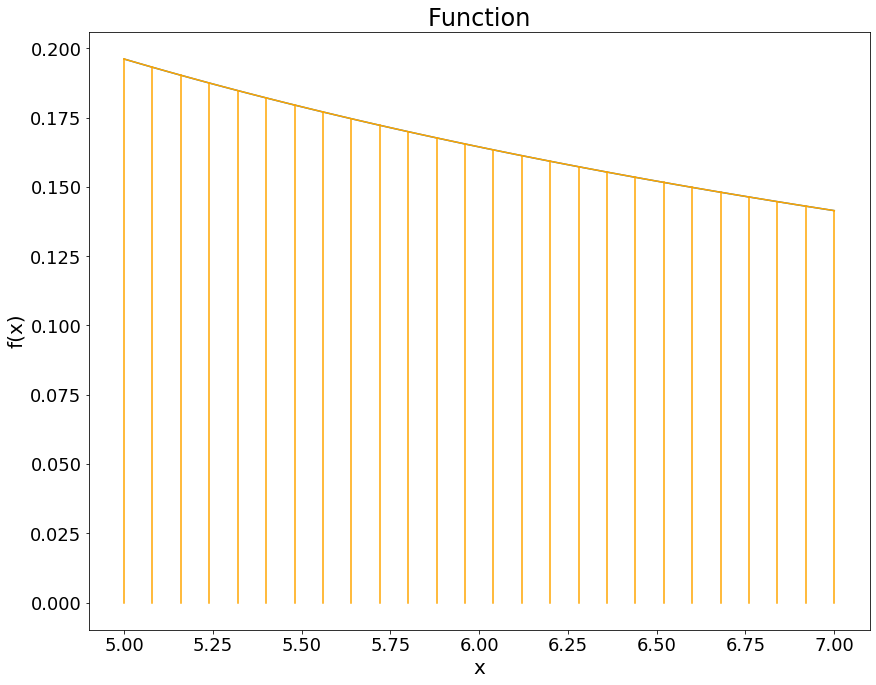

In [58]:
f.draw(include_segments=True, segments_count=25)

Let's plot the error value $e(\tau) = |S_D(\tau) - S| $ versus discretization step graph $\tau$ by varying number of discretization steps $N$

In [106]:
f.count_area(segments_count=1, processes=1)

0.33753749137549355

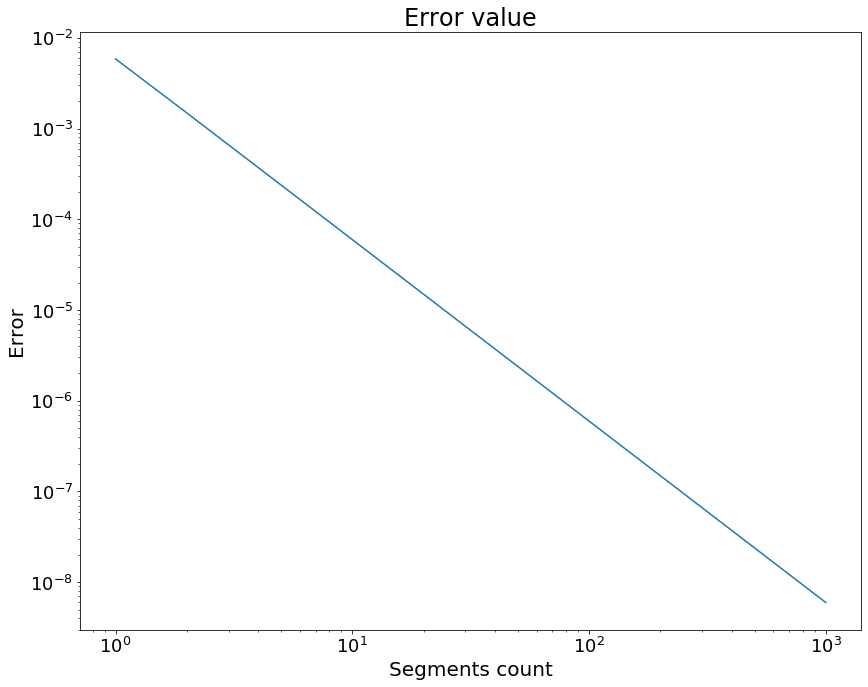

In [95]:
segment_counts = range(1, 1001)
errors = []

for s in segment_counts:
    errors.append(abs(f.count_area(segments_count=s, processes=1) - fexact_solution))

plt.title('Error value')
plt.plot(segment_counts, errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Segments count')
plt.ylabel('Error')
plt.show()

Let's try more complicated diapason of the same funcation

In [96]:
a1, b1 = -10, 10
f1exact_solution = math.log(abs(b1 + math.sqrt(b1**2 + 1))) - math.log(abs(a1 + math.sqrt(a1**2 + 1)))
f1exact_solution

5.996445900595946

In [97]:
f.diapason = (a1, b1)

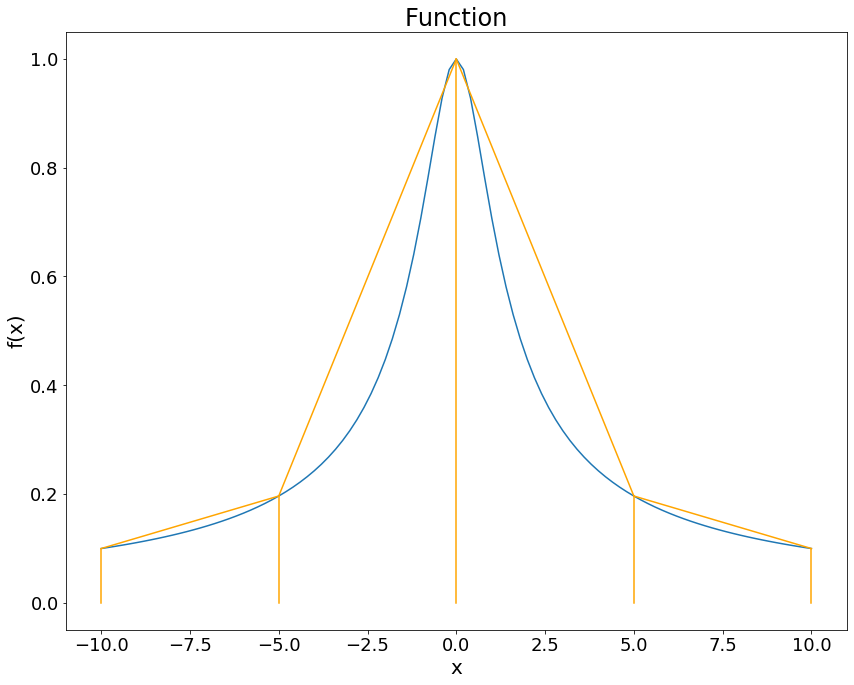

In [98]:
f.draw(include_segments=True, segments_count=4)

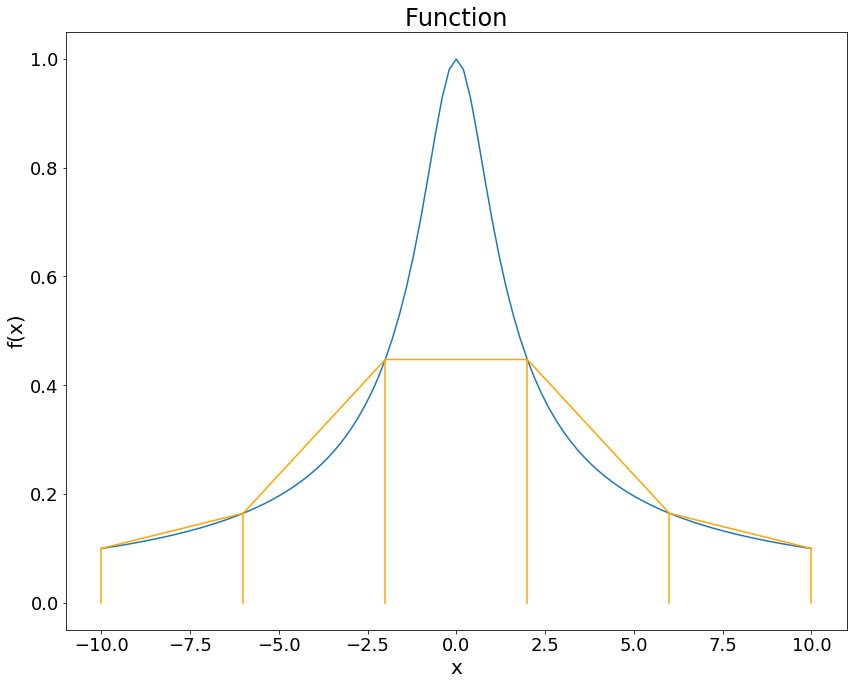

In [99]:
f.draw(include_segments=True, segments_count=5)

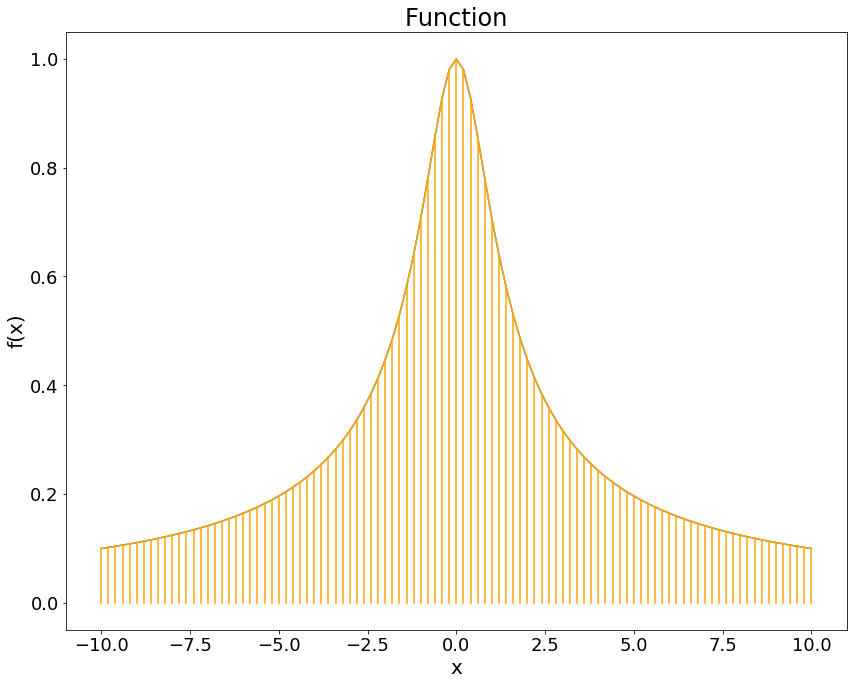

In [100]:
f.draw(include_segments=True, segments_count=100)

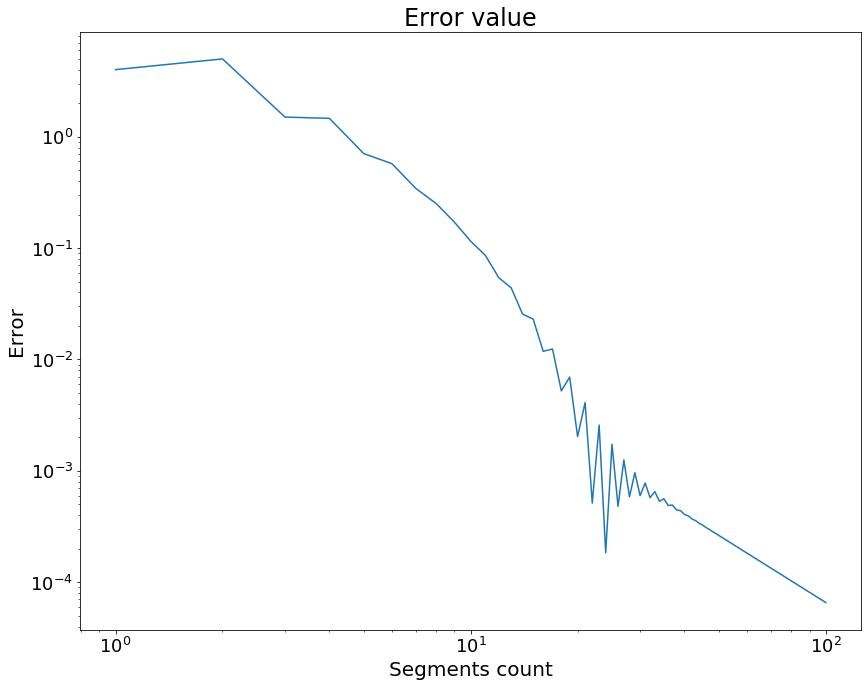

In [102]:
segment_counts = range(1, 101)
errors1 = []

for s in segment_counts:
    errors1.append(abs(f.count_area(segments_count=s, processes=1) - f1exact_solution))

plt.title('Error value')
plt.plot(segment_counts, errors1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Segments count')
plt.ylabel('Error')
plt.show()

We can see some jumps in the error value because in considered symmetric function it is beter to have even amount of segments to divide in the middle.

Calculate segments in parallel

In [4]:
!mpirun -n 5 python Integral_parallel.py

0.33168301697301333


In [31]:
%%bash
for i in `seq 1 32`
do
mpirun -n $i python Integral_parallel.py
done

Process is terminated.


In [42]:
def plot_time(segments_count):
    for i in segments_count:
        f = open('data/integral_time_' + str(i) +'.txt', "r")
        tm = f.readlines()
        f.close()
        
        tm = [int(float(t.split()[1])) for t in tm]
        tm = tm[:12]
        plt.title(str(i) + ' segments')
        plt.plot(range(len(tm)), tm, label=str(i) + ' segments')
        plt.xlabel('Processes count')
        plt.ylabel('Time, ms')
    
        plt.show()
        

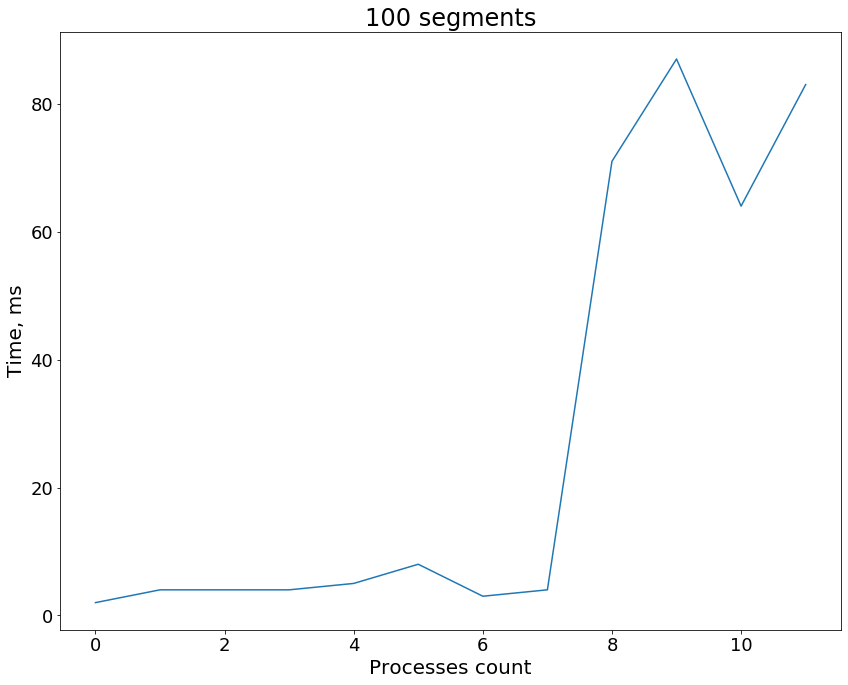

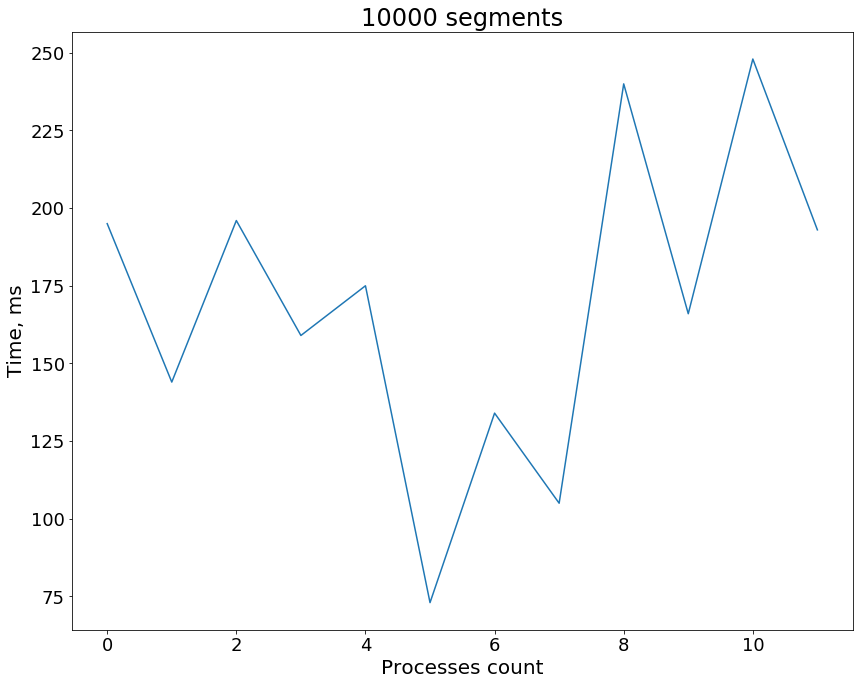

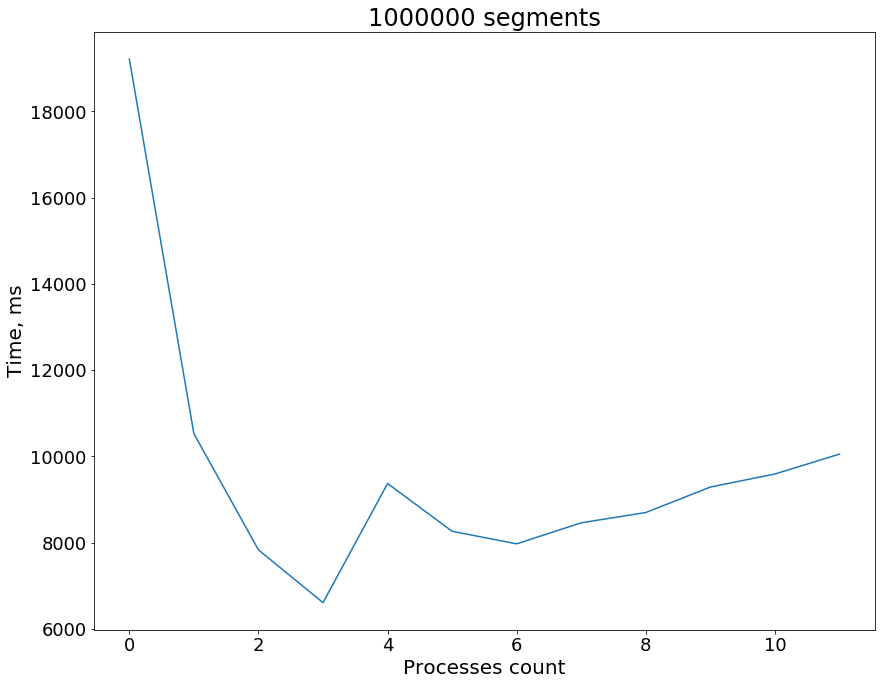

In [43]:
plot_time([100, 10000, 1000000])